# Step 1:  Importing libraries, loading dataset, data pre-processing 

## Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tools.sm_exceptions import ConvergenceWarning

## Load the dataset

In [3]:
df = pd.read_csv('dataset.csv')
df.describe()

,Country Code,Variable1,Variable2,Variable3,Variable4,Variable5,Variable6,Variable7,Variable8
count,900.000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,3.000,654.140604,992.162694,860.950398,1193.896928,300.160077,93.254708,6.997138,3.513587
std,1.415,95.906669,148.707423,127.673392,176.120856,61.134265,24.457290,0.314615,1.010371
min,1.000,431.828871,628.828791,555.593859,789.999722,174.915319,36.717848,6.322031,0.835181
25%,2.000,578.333716,874.103047,759.715383,1064.852861,248.604137,75.359771,6.736462,2.788703
50%,3.000,656.648979,988.175725,864.267063,1191.628522,298.777059,91.989643,7.003694,3.512802
75%,4.000,733.605299,1110.620632,963.908236,1338.318430,353.917602,110.104054,7.250603,4.285253
max,5.000,890.240875,1335.033702,1175.866504,1610.042249,430.124750,195.226302,7.697343,6.131914


## Dataset dimensions and datatypes

In [4]:
print("\nDataset Shape:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)


Dataset Shape:
Number of rows: 900
Number of columns: 12

Column Names:
['Country Code', 'Country', 'Location', 'Variable1', 'Variable2', 'Variable3', 'Variable4', 'Variable5', 'Variable6', 'Variable7', 'Variable8', 'Date']

Data Types:
Country Code      int64
Country          object
Location         object
Variable1       float64
Variable2       float64
Variable3       float64
Variable4       float64
Variable5       float64
Variable6       float64
Variable7       float64
Variable8       float64
Date             object
dtype: object


## Check for duplicates

In [5]:
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")


Duplicate rows: 0


## Check for missing values

In [6]:
print("\nMissing Values by Column:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"Total missing values: {df.isnull().sum().sum()}")


Missing Values by Column:
Country Code    0
Country         0
Location        0
Variable1       0
Variable2       0
Variable3       0
Variable4       0
Variable5       0
Variable6       0
Variable7       0
Variable8       0
Date            0
dtype: int64
Total missing values: 0


In [8]:
# Calculate the year offset for each row based on sequential months within each location
df['year_offset'] = df.groupby('Location').cumcount() // 12

# Calculate the correct year starting from 2019
df['correct_year'] = 2019 + df['year_offset']

# Parse the original 'Date' column into datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Update the 'Date' column with the correct year, preserving the original month and day
df['Date'] = pd.to_datetime({
    'year': df['correct_year'],
    'month': df['Date'].dt.month,
    'day': df['Date'].dt.day
})

# Drop temporary columns to keep only the original dataset structure with corrected dates
df.drop(['year_offset', 'correct_year'], axis=1, inplace=True)

## Transform to more consistent datatypes

In [10]:
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df['Country'] = df['Country'].astype('string')
df['Location'] = df['Location'].astype('string')

## Convert float columns to have maximum 2 decimal places

In [12]:
float_columns = ['Variable1', 'Variable2', 'Variable3', 'Variable4', 'Variable5', 'Variable6', 'Variable7','Variable8']

for column in float_columns:
    df[column] = df[column].round(2)

## Outlier Detection

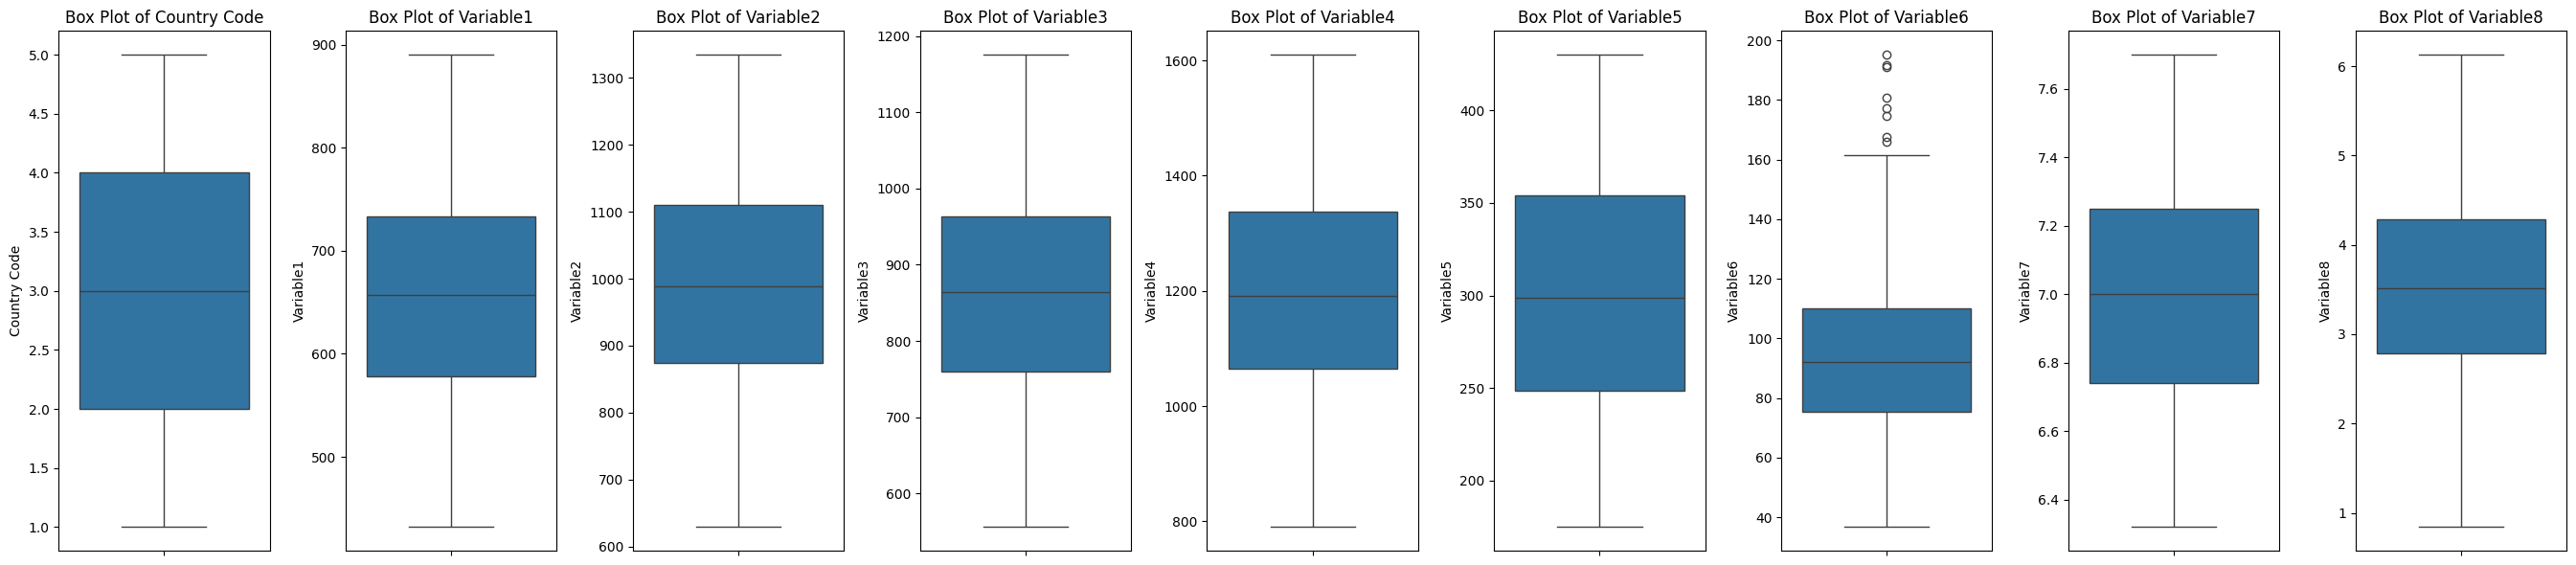

In [13]:
# Generate individual box plots for each numerical column
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Set up subplots
fig, axes = plt.subplots(ncols=len(num_cols), figsize=(len(num_cols) * 3, 6))

# Create a box plot for each column
for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()


In [14]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

# Detect outliers
outliers_dict = detect_outliers_iqr(df, num_cols)

# Display count of outliers per column
outliers_summary = {col: len(outliers) for col, outliers in outliers_dict.items() if len(outliers) > 0}
outliers_summary

{'Variable6': 8}

In [16]:

freight_outliers = outliers_dict['Variable6']
df_outliers = df.loc[freight_outliers.index]

# Display the outlier records
df_outliers

,Country Code,Country,Location,Variable1,Variable2,Variable3,Variable4,Variable5,Variable6,Variable7,Variable8,Date
48,1,United Kingdom,Newcastle,799.56,1223.70,1044.12,1439.94,354.47,167.52,7.25,5.02,2023-01-01
276,2,Ireland,Cork,654.53,1017.99,836.16,1225.82,345.53,165.99,7.11,3.82,2022-01-01
288,2,Ireland,Cork,743.26,1119.75,983.95,1314.27,360.65,195.23,7.50,3.91,2023-01-01
588,4,Italy,Rome,700.93,1113.28,969.78,1216.56,384.07,174.72,7.40,5.63,2023-01-01
648,4,Italy,Florence,790.86,1164.81,1048.77,1390.81,349.45,180.92,7.29,4.88,2023-01-01
768,5,Canada,Toronto,800.81,1229.14,1028.40,1488.55,362.06,177.21,7.49,4.27,2023-01-01
828,5,Canada,Montreal,701.70,1027.63,934.80,1228.71,368.53,191.84,7.46,5.00,2023-01-01
888,5,Canada,Vancouver,771.07,1142.46,1018.08,1392.55,345.01,191.08,7.27,4.30,2023-01-01


## Printing and verifying the cleaned data

In [17]:
df
df1 = df.copy()
df

,Country Code,Country,Location,Variable1,Variable2,Variable3,Variable4,Variable5,Variable6,Variable7,Variable8,Date
0,1,United Kingdom,Newcastle,530.96,807.76,681.98,1064.86,191.31,93.74,6.53,1.89,2019-01-01
1,1,United Kingdom,Newcastle,567.51,845.60,723.01,1048.51,228.02,71.74,6.58,1.67,2019-02-01
2,1,United Kingdom,Newcastle,543.43,845.28,699.60,985.76,218.65,70.04,6.58,1.19,2019-03-01
3,1,United Kingdom,Newcastle,576.24,869.36,773.09,1096.28,199.01,73.54,6.68,2.25,2019-04-01
4,1,United Kingdom,Newcastle,529.41,785.58,721.75,926.53,224.54,45.73,6.59,1.81,2019-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...
895,5,Canada,Vancouver,830.15,1277.82,1104.81,1466.50,399.65,115.83,7.37,4.57,2023-08-01
896,5,Canada,Vancouver,824.41,1253.74,1061.82,1512.30,400.68,107.74,7.56,4.81,2023-09-01
897,5,Canada,Vancouver,820.92,1201.33,1061.15,1504.81,392.53,132.41,7.54,5.92,2023-10-01
898,5,Canada,Vancouver,837.69,1270.94,1094.50,1509.95,412.59,112.70,7.48,5.17,2023-11-01


# Step 2: Data Analysis and Visualisation

## Time-Series Decomposition of Pulp Prices by Country
This code sorts the DataFrame by 'Date', extracts unique countries, and groups data by 'Date' and 'Country' to calculate mean numeric values, then uses seasonal decomposition to plot the observed, trend, seasonal, and residual components of pulp prices for each country, providing insights into seasonal patterns and trends.

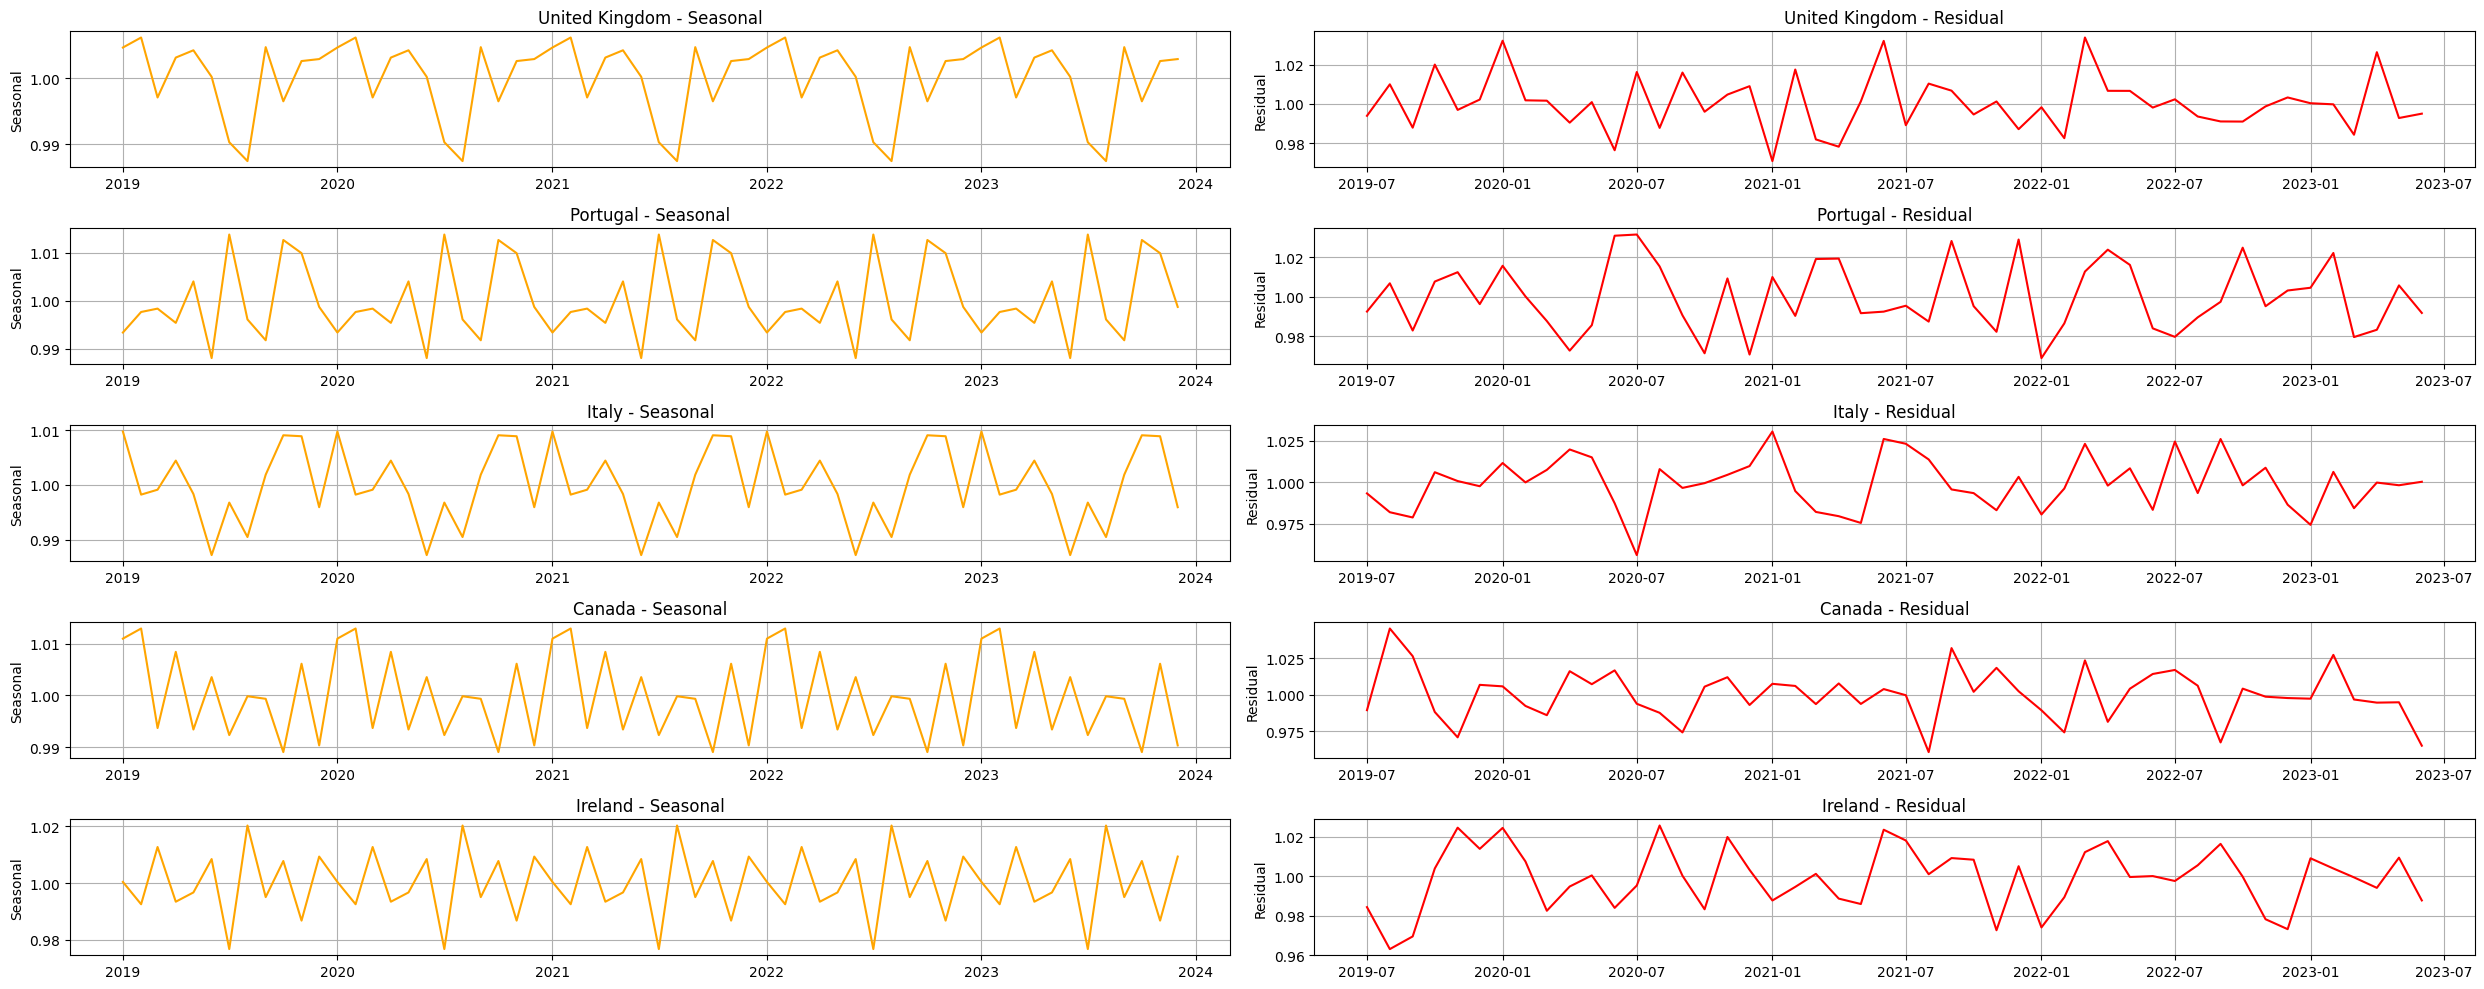

In [18]:
df = df.sort_values('Date')

# Extract all unique countries dynamically
all_countries = df['Country'].unique()

# Group data by Date and Country
grouped = df.groupby(['Date', 'Country']).mean(numeric_only=True).reset_index()

# Create the figure with a 2x5 grid (2 rows, 5 columns)
fig, axes = plt.subplots(len(all_countries), 2, figsize=(25, 10))

# Flatten axes for easy indexing
axes = axes.flatten()

# Iterate through the countries and plot seasonal and residual components
for idx, country in enumerate(all_countries):  # Iterate through all countries
    country_data = grouped[grouped['Country'] == country].set_index('Date')
    decomposition = seasonal_decompose(country_data['Variable1'], model='multiplicative', period=12)
    
    # Plot Seasonal
    axes[idx * 2].plot(decomposition.seasonal, label='Seasonal', color='orange')
    axes[idx * 2].set_ylabel('Seasonal')
    axes[idx * 2].set_title(f'{country} - Seasonal')
    axes[idx * 2].grid(True)

    # Plot Residual
    axes[idx * 2 + 1].plot(decomposition.resid, label='Residual', color='red')
    axes[idx * 2 + 1].set_ylabel('Residual')
    axes[idx * 2 + 1].set_title(f'{country} - Residual')
    axes[idx * 2 + 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Rolling Average Visualization of Pulp Prices Across Countries
This code dynamically creates a grid of subplots based on the number of unique countries, plotting the original pulp prices and their 3-month rolling averages for each country to smooth out short-term fluctuations, allowing for a clear comparison of price trends over time.

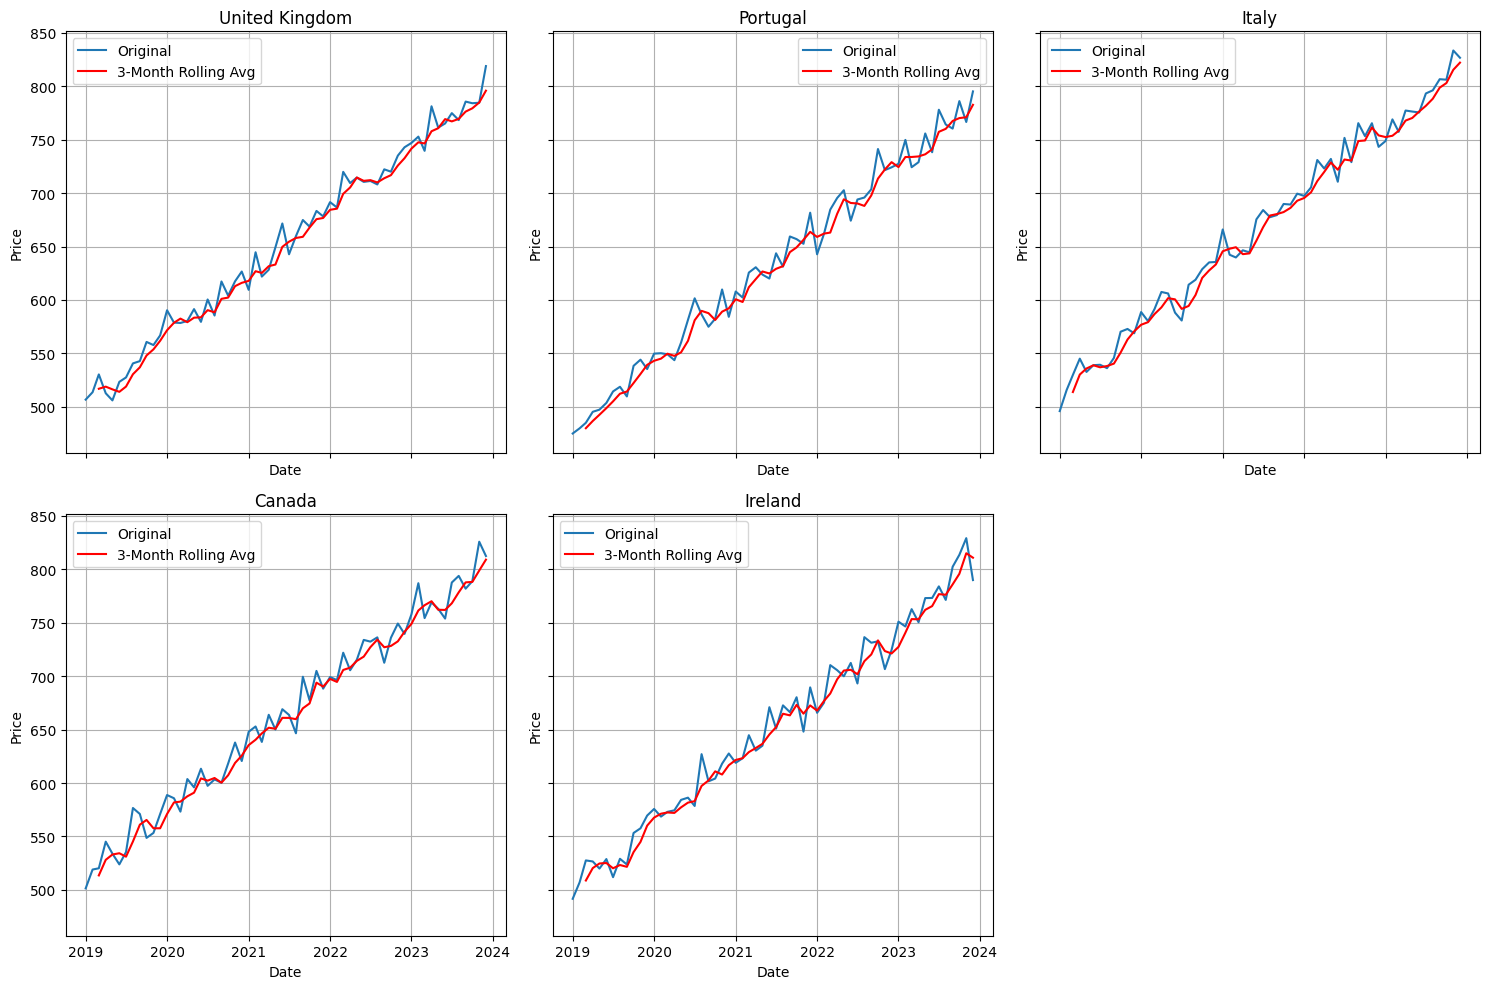

In [19]:
# Define subplot grid size
num_countries = len(all_countries)
rows = (num_countries // 3) + (num_countries % 3 > 0)  # Adjust rows dynamically
cols = min(num_countries, 3)  # Max 3 columns

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten in case of multi-row layout

for i, country in enumerate(all_countries):
    country_data = grouped[grouped['Country'] == country].set_index('Date')
    rolling_avg = country_data['Variable1'].rolling(window=3).mean()
    
    ax = axes[i]
    ax.plot(country_data.index, country_data['Variable1'], label='Original')
    ax.plot(rolling_avg.index, rolling_avg, label='3-Month Rolling Avg', color='red')
    ax.set_title(f'{country}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Freight Costs Volatility Visualization by Location
This code iterates over each unique location in the dataset, computing and plotting the 3-month rolling standard deviation of freight costs over time to visualize volatility, helping identify regions with unstable shipping costs.

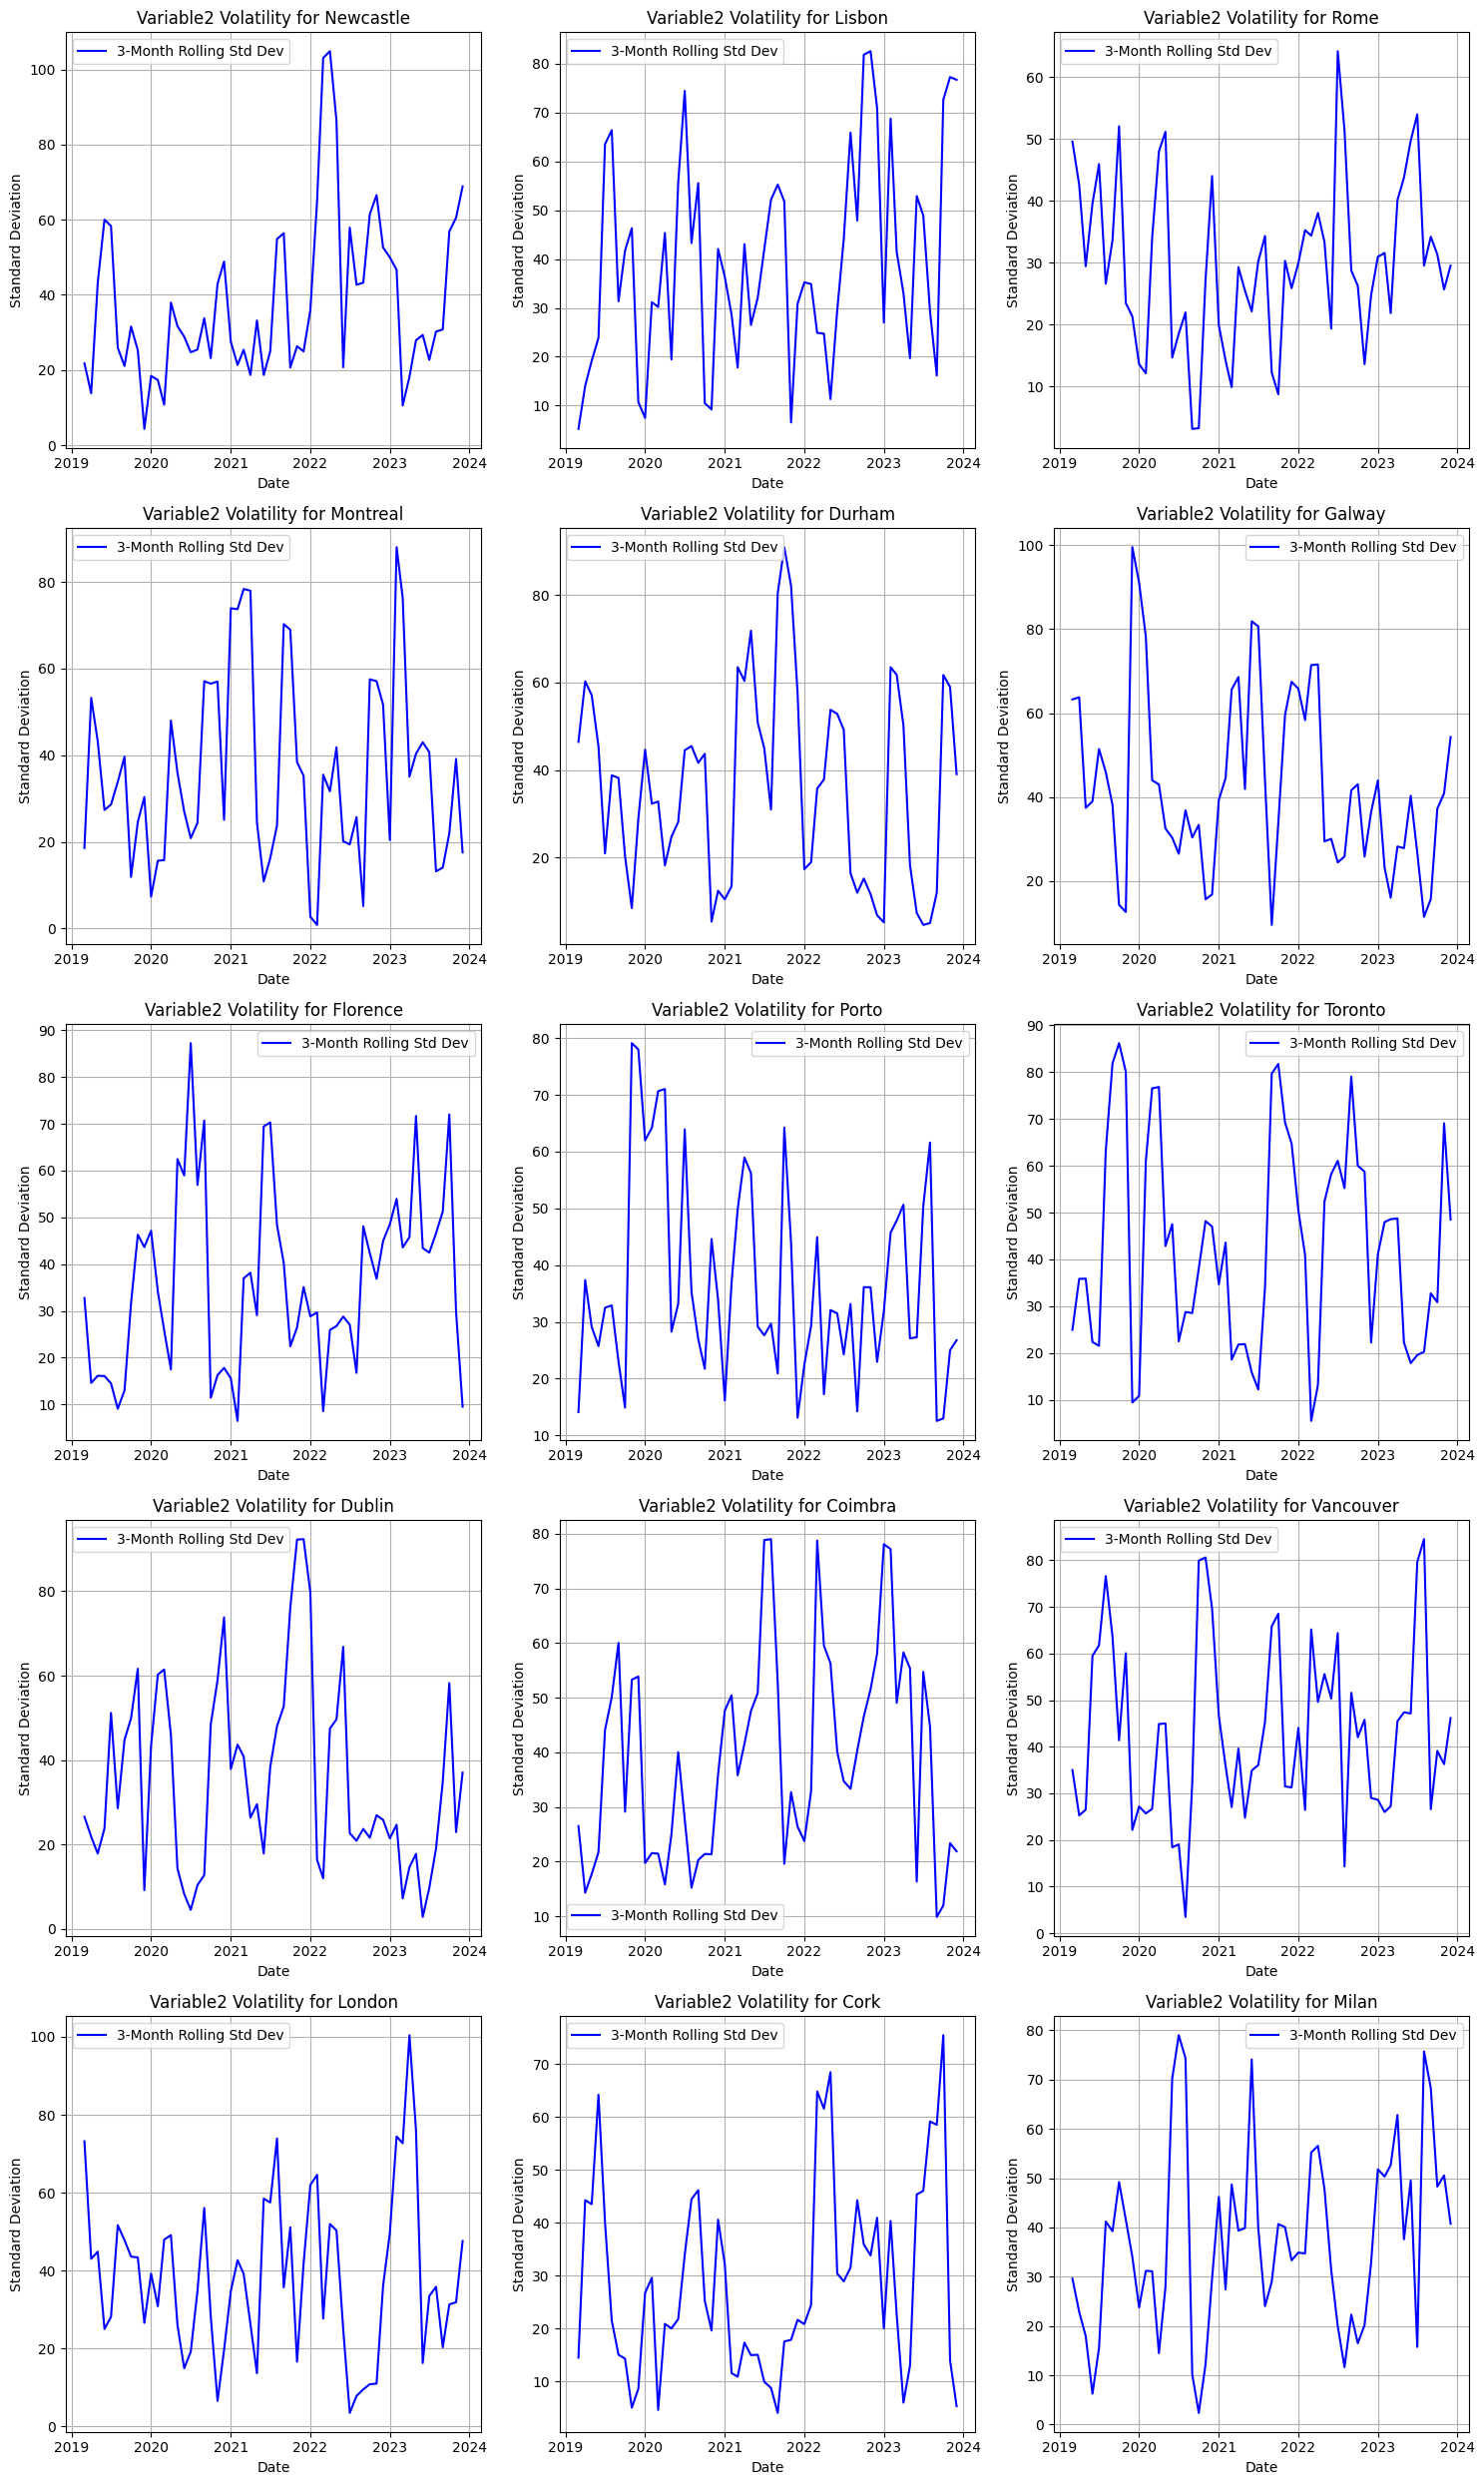

In [20]:
# Create subplots for each location
all_locations = df['Location'].unique()
num_locations = len(all_locations)

# Calculate the number of rows and columns for subplots based on the number of locations
ncols = 3
nrows = (num_locations // ncols) + (num_locations % ncols != 0)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axes array if necessary (for easier indexing)
axes = axes.flatten()

# Iterate over each location and plot the data on the corresponding subplot
for idx, location in enumerate(all_locations):
    # Filter the original DataFrame by location and set 'Date' as index
    location_data = df[df['Location'] == location].set_index('Date')
    
    # Compute the 3-month rolling standard deviation
    rolling_std = location_data['Variable2'].rolling(window=3).std()
    
    # Plot on the appropriate axis
    ax = axes[idx]
    ax.plot(rolling_std.index, rolling_std, label='3-Month Rolling Std Dev', color='blue')
    ax.set_title(f'Variable2 Volatility for {location}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Standard Deviation')
    ax.legend()
    ax.grid(True)

# Remove any unused subplots if the number of locations isn't a perfect fit
for idx in range(num_locations, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Correlation Analysis of Event Impact with Economic Factors
This code creates a binary variable indicating event occurrence, computes correlations between numeric columns (e.g., prices, freight costs) and the event indicator, and visualizes them in a heatmap to identify how external events like the US-China trade war influence paper industry metrics.

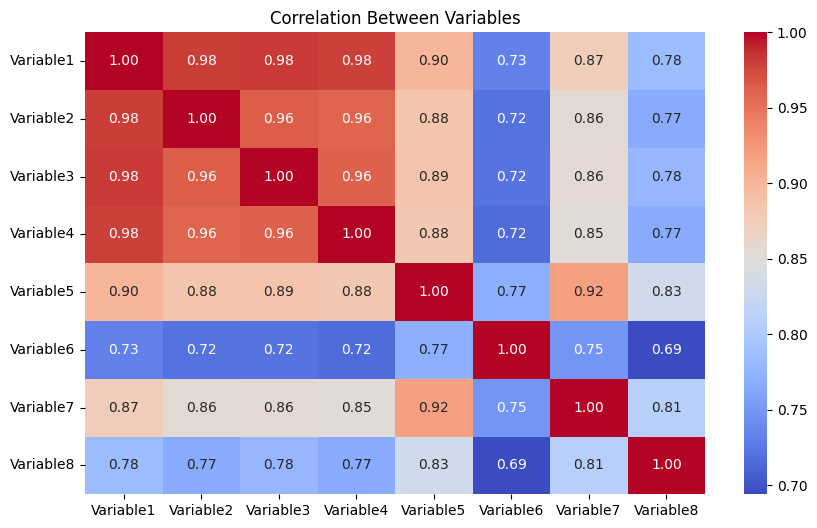

In [22]:
# Define columns to compare
numeric_columns = ['Variable1', 'Variable2', 'Variable3', 'Variable4', 'Variable5', 'Variable6', 'Variable7','Variable8']
# Compute correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Variables")
plt.show()

## Pairwise Relationships Visualization of Numeric Columns
This code uses a pairplot to visualize pairwise relationships and distributions (via KDE plots) of numeric columns in the dataset, such as prices and economic factors, with regression lines to highlight correlations, aiding in understanding interdependencies within the paper industry data.

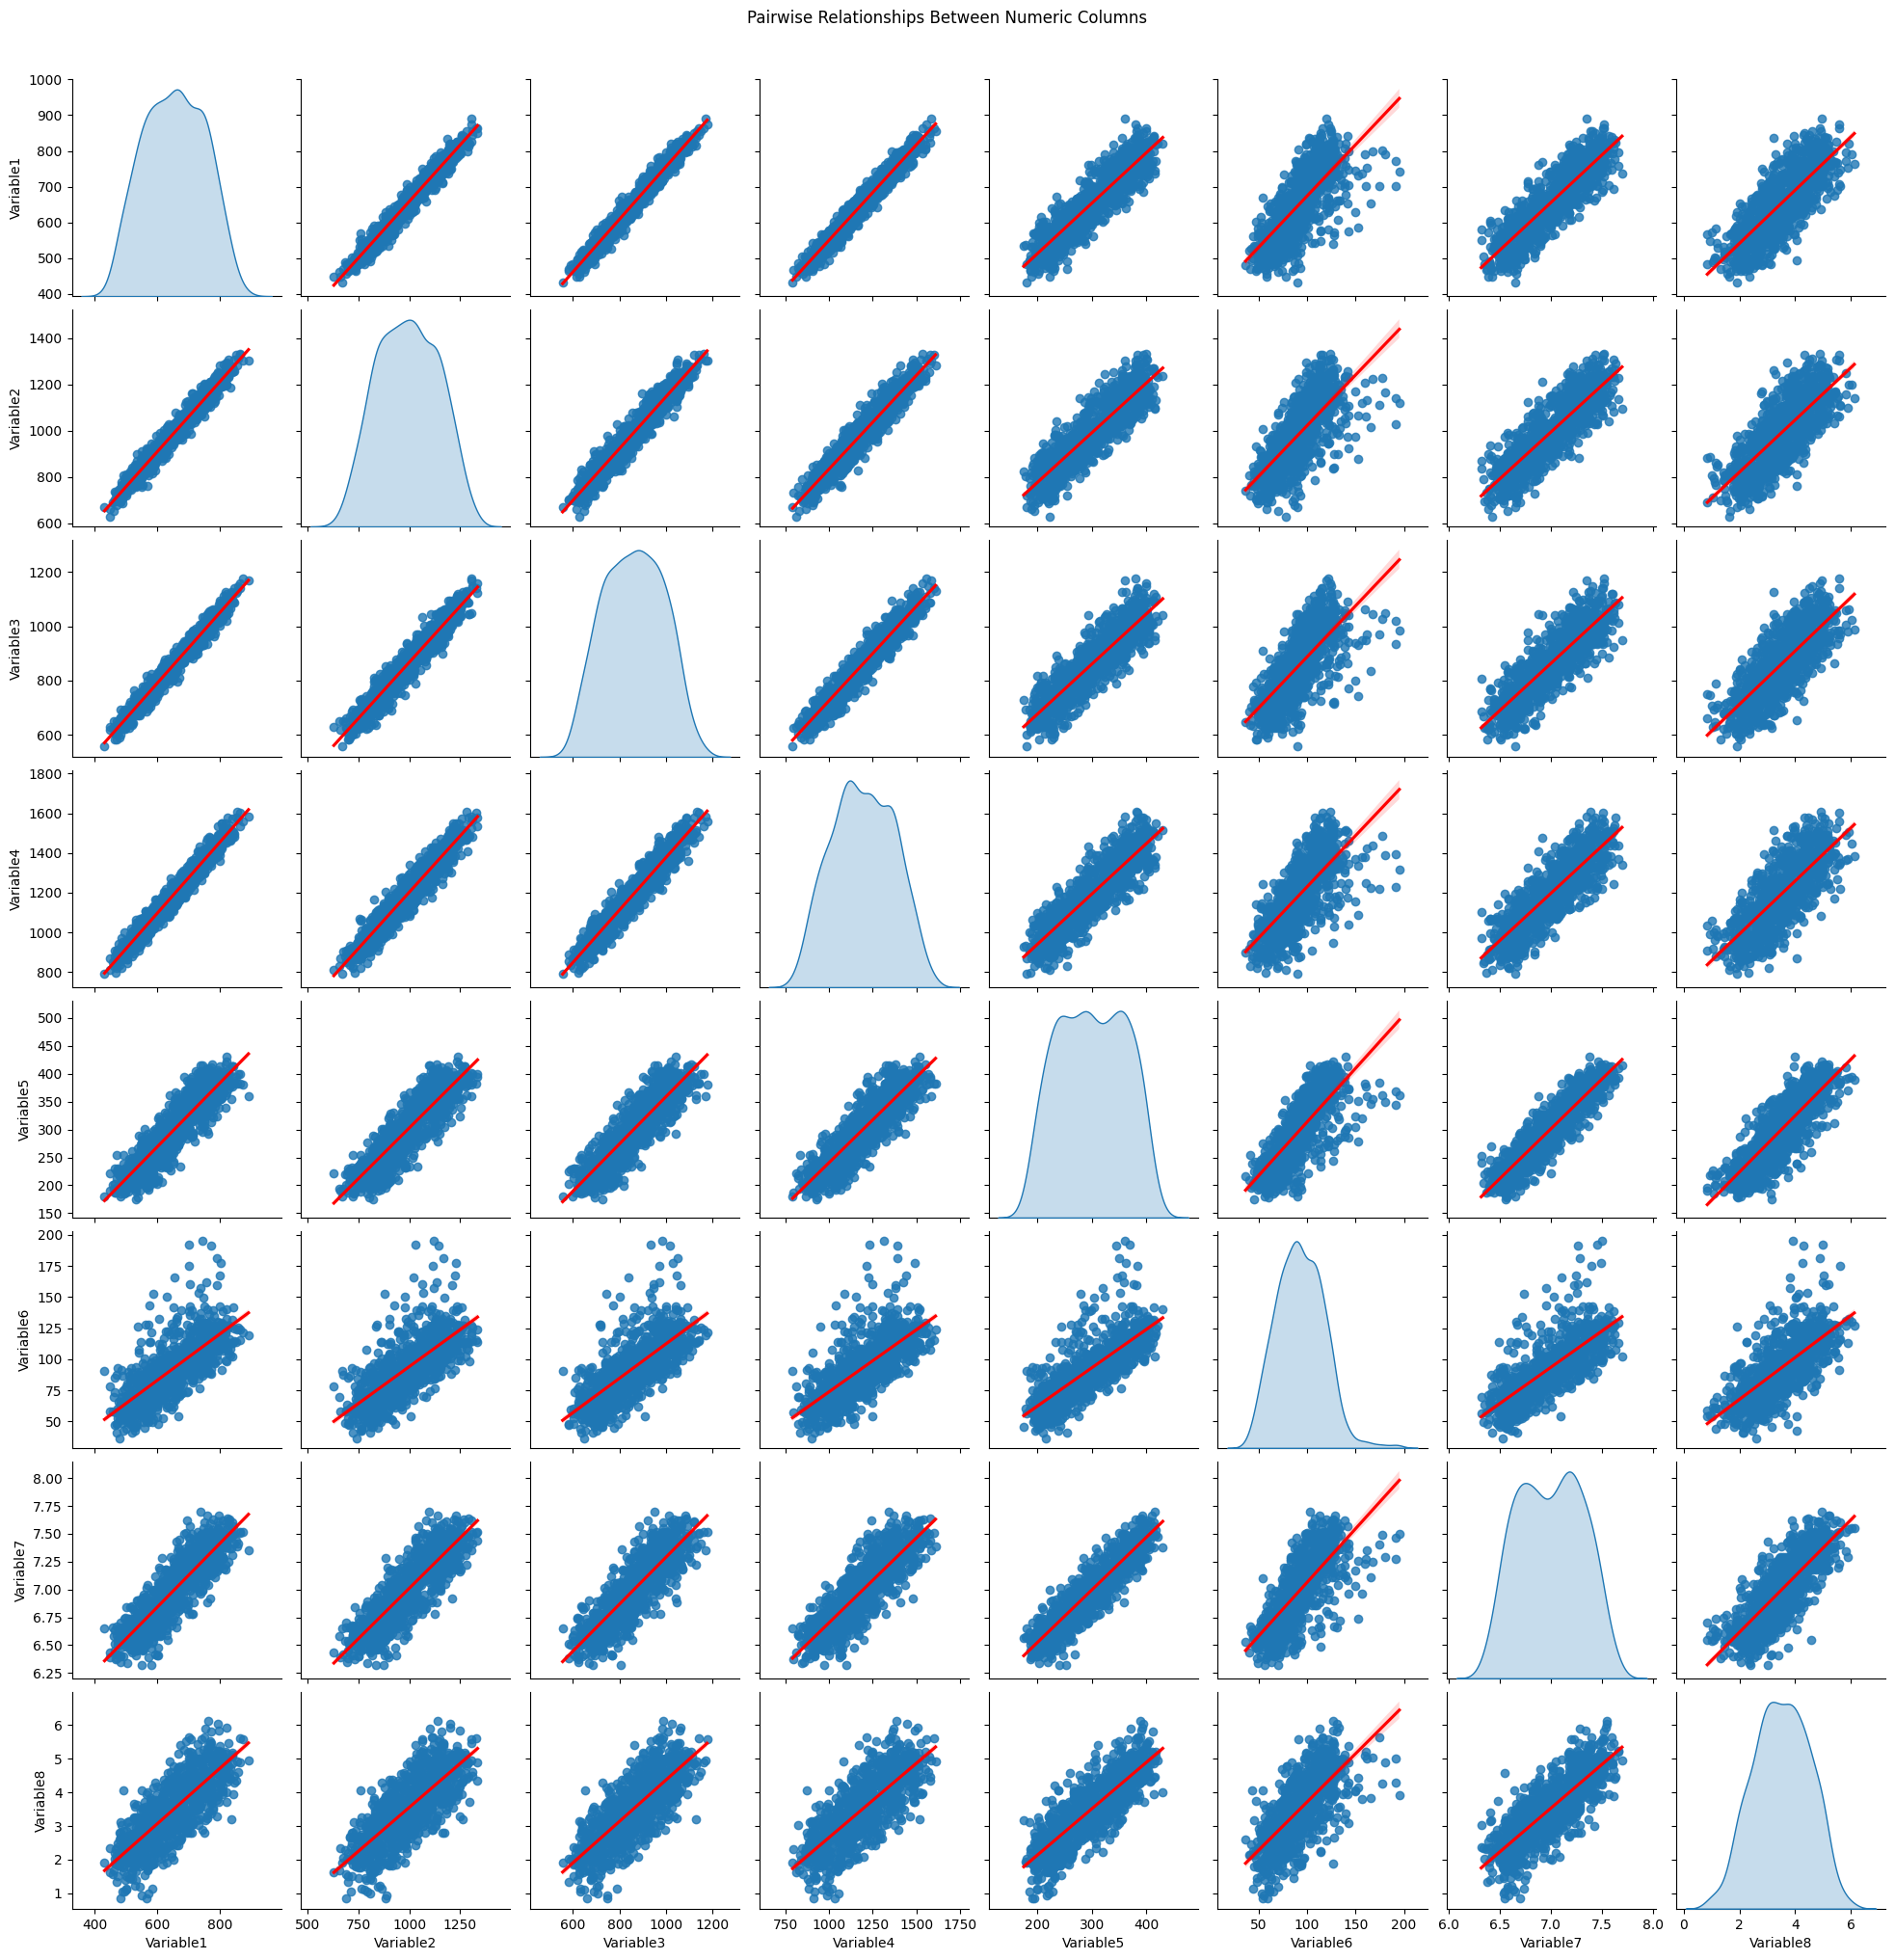

In [23]:
numeric_columns = df.select_dtypes(include=['float64']).columns
# Plot pairwise relationships using seaborn pairplot
sns.pairplot(df[numeric_columns], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Pairwise Relationships Between Numeric Columns', y=1.02)
plt.show()

## Time-Series Visualization of Paper Prices by Country
This code creates a 3x3 grid of line plots to visualize the mean prices over time for pulp, kraft paper, newsprint, corrugated packaging, and recycled fiber across five countries (India, China, Germany, France, USA), using markers and legends to compare regional price trends and identify seasonal or event-driven patterns.

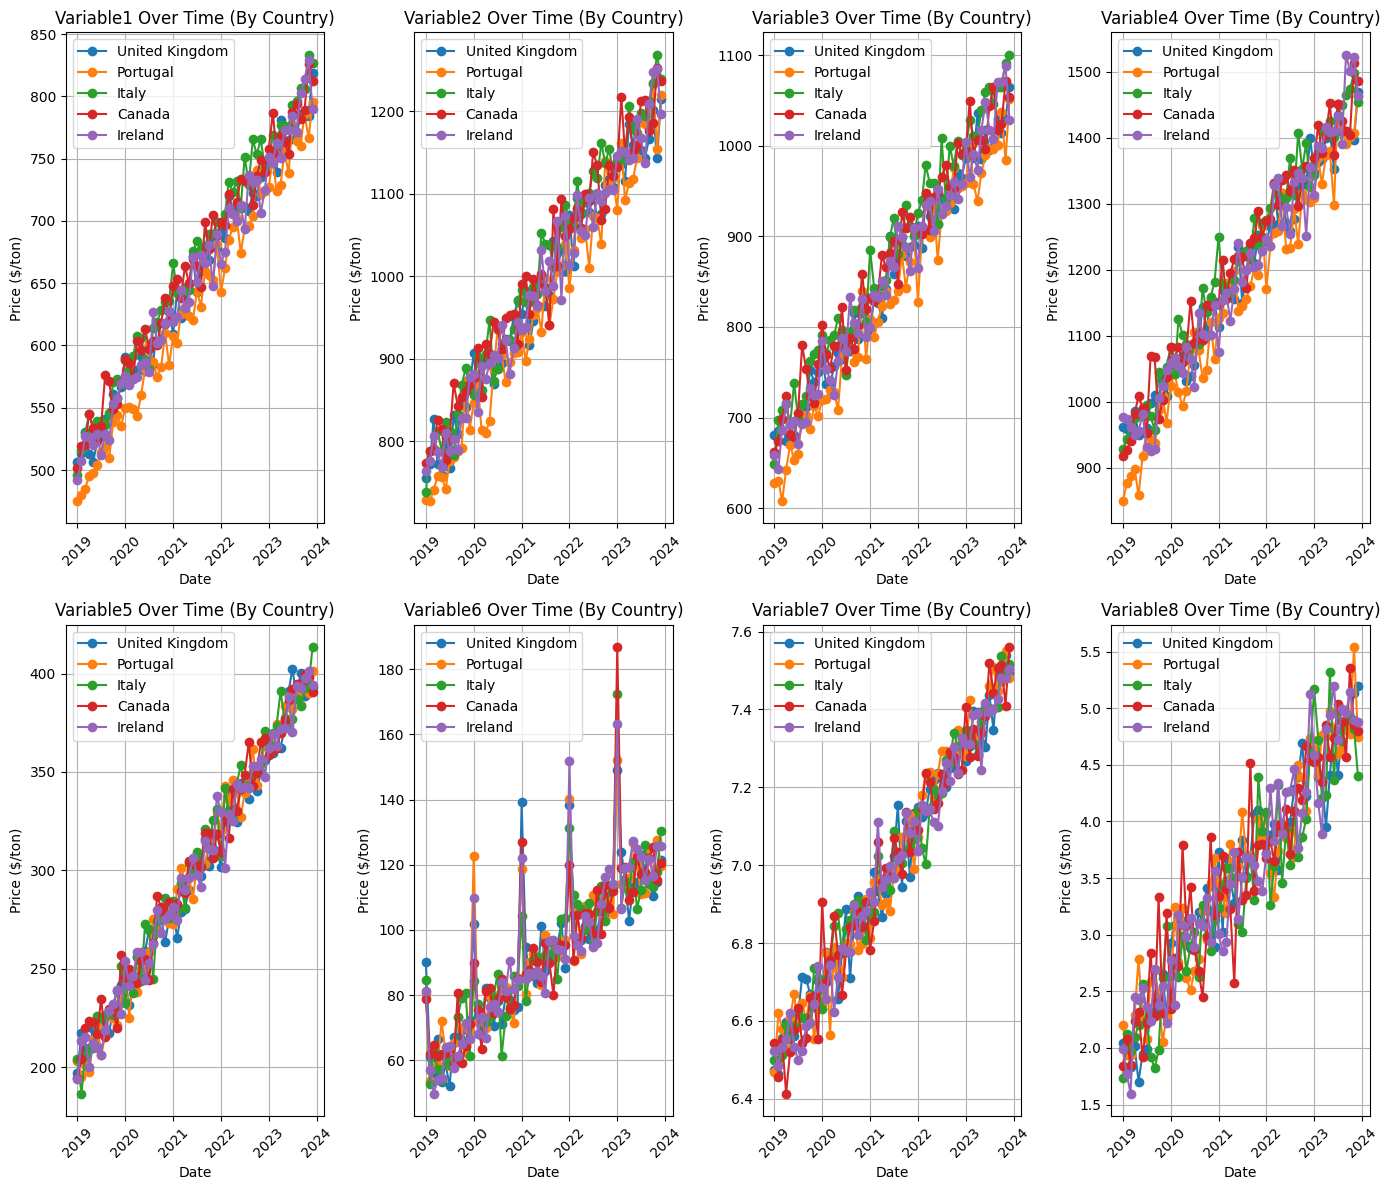

In [25]:
# List of price types for Figure 1
price_types = ['Variable1', 'Variable2', 'Variable3', 'Variable4', 'Variable5', 'Variable6', 'Variable7','Variable8']

# 2×3 GRID FOR PAPER PRICES
fig1, axes1 = plt.subplots(nrows=2, ncols=4, figsize=(14, 12))
axes1 = axes1.flatten()  # Flattening for easier iteration

for i, price in enumerate(price_types):
    aggregated_df = df.groupby(['Date', 'Country'])[price].mean().reset_index()
    
    for country in all_countries:
        country_data = aggregated_df[aggregated_df['Country'] == country]
        axes1[i].plot(country_data['Date'], country_data[price], label=country, marker='o')

    axes1[i].set_title(f"{price} Over Time (By Country)")
    axes1[i].set_xlabel("Date")
    axes1[i].set_ylabel("Price ($/ton)")
    axes1[i].legend()
    axes1[i].grid(True)
    axes1[i].tick_params(axis='x', rotation=45)  # Slanted x-axis labels

plt.tight_layout()
plt.show()

# Step 3: Forecasting and Modeling

## SARIMAX Model

The SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variables) model was selected for forecasting paper prices due to its ability to handle time-series data with seasonal patterns and external influences, critical for the paper industry’s dynamics. It extends the ARIMA model by incorporating seasonal component, exogenous variables and demand fluctuations.

### Components:
Autoregression (AR): As before, autoregression examines past values of the time series to predict current values. <br>
Moving average (MA): The moving average continues to model past errors in predictions. <br>
Integration (I): Integration is always present to make the time series stationary. <br>
Seasonal component (S): The seasonal component captures variations that recur at regular intervals. <br>
eXogenous variables (X): Covariates are external variables that can influence the time series. <br>

### Model Assumptions: 
Stationarity is crucial for various time series models. Non-stationary data can lead to inaccurate forecasts due to violated assumptions. In a stationary series, the mean and variance are constant, making the data easier to interpret without major shifts or fluctuations.

### Applications of SARIMAX:
Data Analysis <br>
Model building <br>
Validation and forecasting <br>

### Univariate Forecasting

Please specify the scope of the forecast:
- Type 'global' for an aggregated forecast across all countries.
- Type a country or location name for a specific forecast.


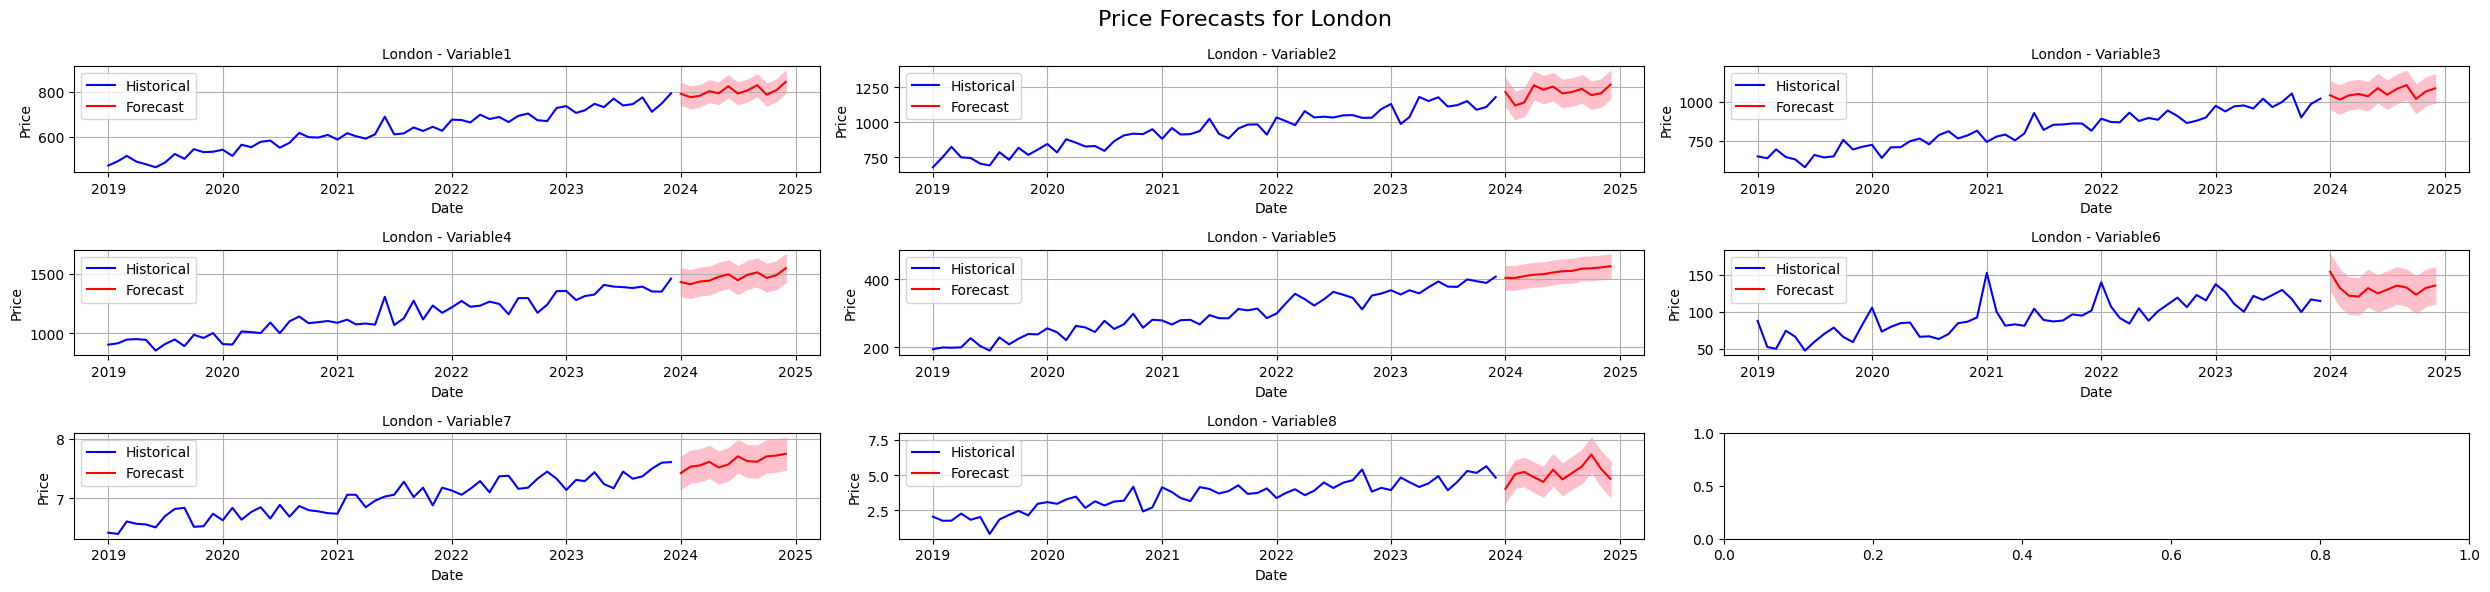

In [27]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppresses UserWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Suppresses ConvergenceWarnings

# Define the price types for forecasting
price_types = ['Variable1', 'Variable2', 'Variable3', 'Variable4', 'Variable5', 'Variable6', 'Variable7','Variable8']

# Prompt the user for input
print("Please specify the scope of the forecast:")  # Display options for forecast scope
print("- Type 'global' for an aggregated forecast across all countries.")  # Option for global forecast
print("- Type a country or location name for a specific forecast.")  # Option for a specific forecast based on country/location
user_input = input("Your choice: ").strip().lower()  # Accept user input and convert it to lowercase

# Identify numeric columns to avoid errors with string columns
numeric_cols = df.select_dtypes(include=['number']).columns  # Select only numeric columns from the DataFrame

# Determine the scope based on user input
if user_input == 'global':  # Check if the user input is 'global'
    # Aggregate data for all countries and locations
    forecast_df = df.groupby('Date')[numeric_cols].mean().reset_index()  # Group by Date and calculate the mean of numeric columns
    title_prefix = "Global"  # Set the title prefix for global data
else:  # If the input is not 'global'
    # Check if the input matches a country or location
    if user_input in df['Country'].str.lower().unique():  # Check if the input is a valid country
        # Filter by country
        forecast_df = df[df['Country'].str.lower() == user_input].groupby('Date')[numeric_cols].mean().reset_index()  # Filter data by country and calculate mean for each Date
        title_prefix = user_input.capitalize()  # Capitalize the user input to use in title
    elif user_input in df['Location'].str.lower().unique():  # Check if the input matches a valid location
        # Filter by location
        forecast_df = df[df['Location'].str.lower() == user_input].groupby('Date')[numeric_cols].mean().reset_index()  # Filter data by location and calculate mean for each Date
        title_prefix = user_input.capitalize()  # Capitalize the user input to use in title
    else:  # If the input is not a valid country or location
        print(f"No data found for '{user_input}'. Please check the country or location name and try again.")  # Print error message
        exit()  # Exit the script if invalid input

# Set 'Date' as index for time series modeling
forecast_df.set_index('Date', inplace=True)  # Set the 'Date' column as the index for the DataFrame

# Set up the 2x3 plot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 6))  # Create a 2x3 grid of subplots, with a figure size of 25x6 inches
axes = axes.flatten()  # Flatten the 2D axes array into 1D for easy access

# Forecasting and plotting for each price type
for idx, price_type in enumerate(price_types):  # Loop over each price type and its index in the price_types list
    ax = axes[idx]  # Select the axis for the current subplot
    prices = forecast_df[price_type]  # Get the price data for the current price type
    
    # Define and fit the SARIMA model
    model = SARIMAX(prices, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Define the SARIMA model with specified orders for AR, I, MA, and seasonality
    results = model.fit()  # Fit the model to the data
    
    # Forecasting for 12 steps (12 months)
    forecast = results.get_forecast(steps=12)  # Forecast the next 12 steps (months) using the fitted model
    forecast_dates = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=12, freq='MS')  # Create a date range for the forecasted periods (starting from the next month)
    ci = forecast.conf_int(alpha=0.05) ## Confidence interval
    # Plot historical data and forecast
    ax.plot(prices.index, prices, label='Historical', color='blue')  # Plot the historical data in blue
    ax.plot(forecast_dates, forecast.predicted_mean, label='Forecast', color='red')  # Plot the forecast in red
    ax.fill_between(forecast_dates, ci.iloc[:, 0], ci.iloc[:, 1], color='pink')  # Plot the confidence interval (shaded area) in pink
    ax.set_title(f'{title_prefix} - {price_type}', fontsize=10)  # Set the title for each subplot (e.g., "Global - Pulp Prices")
    ax.set_xlabel('Date')  # Set the x-axis label as 'Date'
    ax.set_ylabel('Price')  # Set the y-axis label as 'Price ($/ton)'
    ax.legend()  # Show the legend for the plot
    ax.grid(True)  # Enable the grid on the plot for better readability

# Adjust layout and add a main title
fig.suptitle(f'Price Forecasts for {title_prefix}', fontsize=16)  # Add a main title to the entire figure
plt.tight_layout()  # Adjust the layout to prevent overlapping of elements
plt.show()  # Display the plot


### Multivariate Forecasting

#### Corrugated packaging prices fit on variables: Pulp, Inflation, Currency Exchange Rate and Location. The seasonality is also included in the analysis.

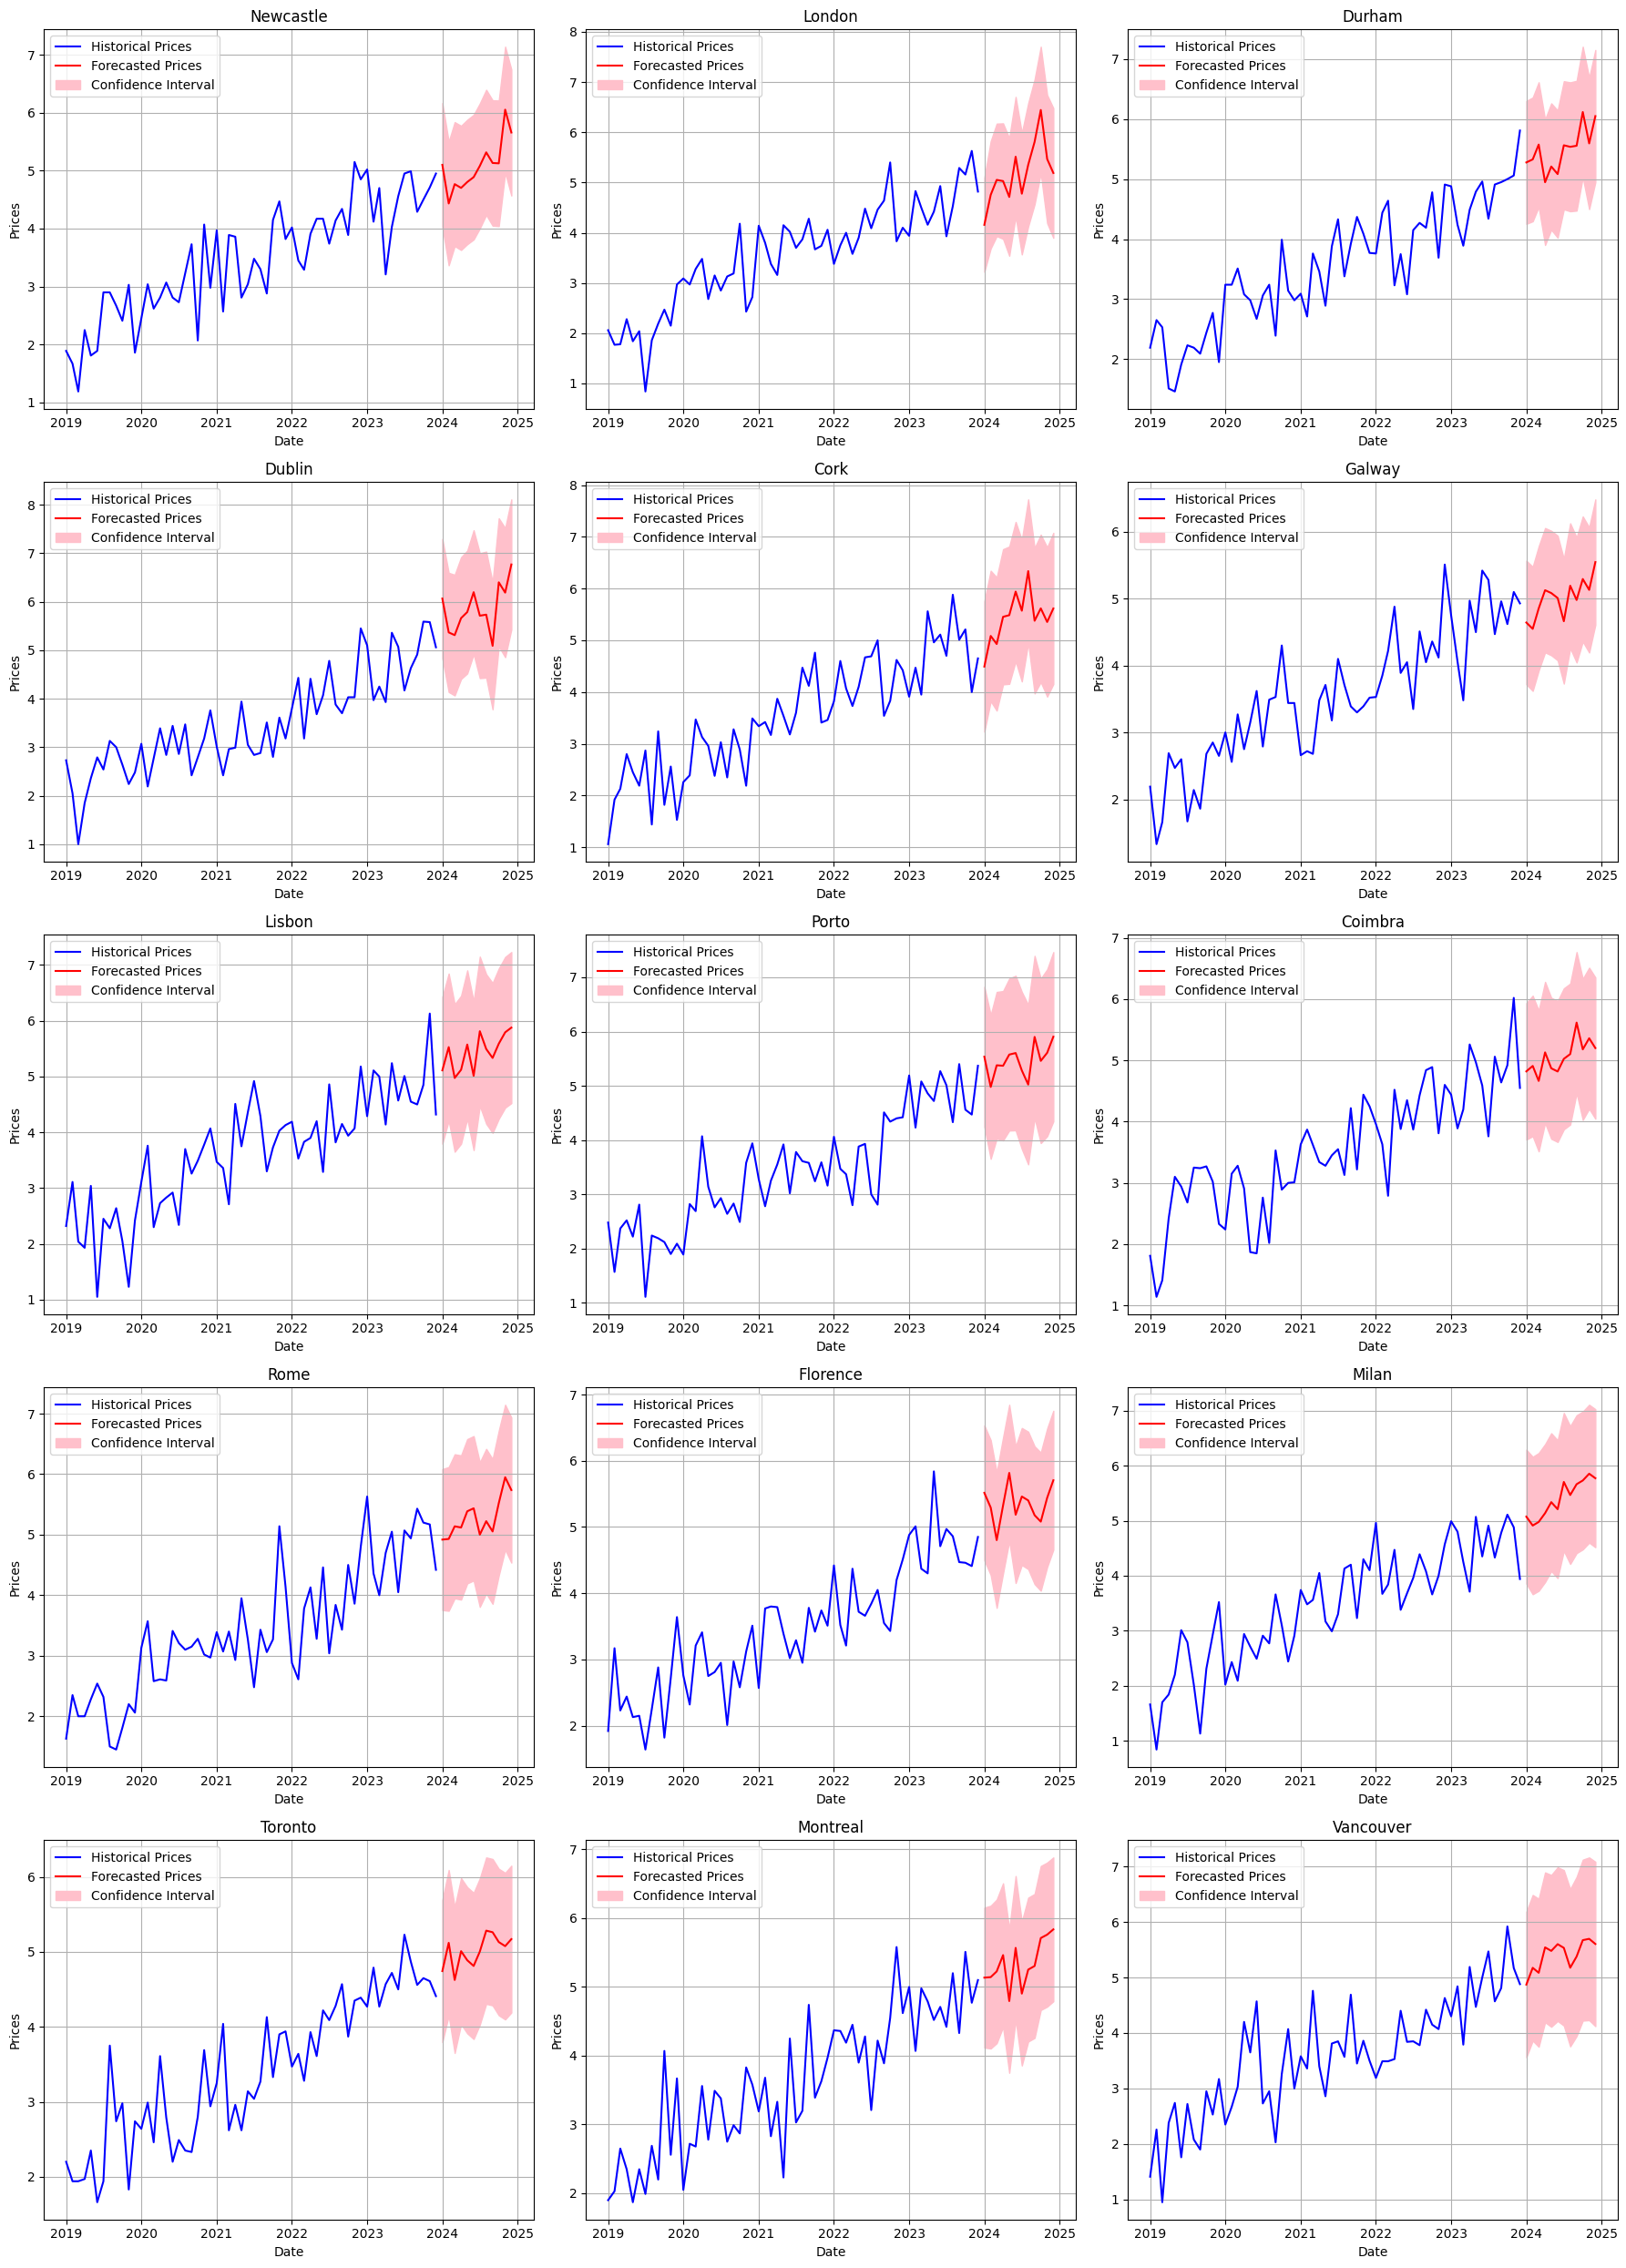

In [29]:
df1['Date'] = pd.to_datetime(df1['Date'])  # Convert the 'Date' column in df1 to datetime format
unique_locations = df1['Location'].unique()  # Get a list of unique locations in the 'Location' column

# Function to fit SARIMAX model for a given location
def fit_sarimax_by_location(location, df1):
    # Filter data for the specific location
    loc_df = df1[df1['Location'] == location].copy()  # Filter the DataFrame for rows corresponding to the location
    
    # Set 'Date' as index and ensure chronological order
    loc_df.set_index('Date', inplace=True)  # Set the 'Date' column as the index for the location-specific data
    loc_df = loc_df.sort_index()  # Sort the DataFrame by the Date index to ensure chronological order
    
    # Set frequency - monthly start
    loc_df = loc_df.asfreq('MS')  # Set the frequency of the DataFrame to monthly start (MS) for time series
    
    # Select target variable and exogenous variables
    y = loc_df['Variable8']  # Target variable: 'Corrugated Packaging Prices ($/ton)'
    exog = loc_df[['Variable1', 'Variable2']]  # Exogenous variables: Currency Exchange Rate and Inflation Rate
    
    # Fit SARIMAX model
    model = SARIMAX(y, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), freq='MS')  # Define and fit the SARIMAX model with specified orders and seasonal period
    results = model.fit()  # Fit the SARIMAX model to the data
    
    # Prepare future exogenous variables
    last_exog = exog.iloc[-1]  # Get the last observed values of the exogenous variables
    future_exog = pd.DataFrame(  # Create a DataFrame for future exogenous variables
        [last_exog] * 12,  # Repeat the last observed exogenous values for 12 months
        index=pd.date_range(start=y.index[-1] + pd.offsets.MonthEnd(), periods=12, freq='MS'),  # Create future dates starting after the last observation
        columns=exog.columns  # Set the same columns as the exogenous variables
    )
    
    # Generate 12-month forecast
    forecast = results.get_forecast(steps=12, exog=future_exog)  # Generate a 12-month forecast using the model and future exogenous variables
    forecast_mean = forecast.predicted_mean  # Get the predicted mean of the forecast
    forecast_ci = forecast.conf_int()  # Get the confidence interval for the forecast

    return y, forecast_mean, forecast_ci, location  # Return the historical data, forecast mean, forecast confidence interval, and location name

# Store plot data
plot_data = []  # Initialize an empty list to store data for plotting

# Fit models and collect data
for location in unique_locations:  # Loop through all unique locations
    try:
        y, forecast_mean, forecast_ci, location = fit_sarimax_by_location(location, df1)  # Fit the SARIMAX model for the current location
        plot_data.append((y, forecast_mean, forecast_ci, location))  # Append the results to the plot_data list
    except Exception as e:  # Handle any exceptions that occur during model fitting
        print(f"Model for {location} failed: {e}")  # Print an error message if the model fitting fails for a location

# Set up the 5x3 grid for visualization
fig, axes = plt.subplots(5, 3, figsize=(18, 25))  # Create a 5x3 grid of subplots with a specified figure size
axes = axes.flatten()  # Flatten the 2D axes array into a 1D array for easier access

# Plot all graphs in the 5x3 grid
for i, (y, forecast_mean, forecast_ci, location) in enumerate(plot_data):  # Loop through the collected plot data
    ax = axes[i]  # Select the axis for the current subplot
    
    # Plot historical data
    ax.plot(y.index, y, label='Historical Prices', color='blue')  # Plot the historical prices in blue
    
    # Plot forecast
    ax.plot(forecast_mean.index, forecast_mean, label='Forecasted Prices', color='red')  # Plot the forecasted prices in red
    
    # Confidence interval shading
    ax.fill_between(forecast_mean.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],  # Fill the area between the lower and upper bounds of the forecast confidence interval
                    color='pink', label='Confidence Interval')  # Shade the confidence interval in pink
    
    ax.set_title(f'{location}')  # Set the title of the subplot to the location name
    ax.set_xlabel('Date')  # Set the x-axis label as 'Date'
    ax.set_ylabel('Prices')  # Set the y-axis label as 'Prices ($/ton)'
    ax.legend()  # Add a legend to the subplot
    ax.grid(True)  # Enable the grid on the subplot for better readability

# Hide any unused subplots
for j in range(i + 1, len(axes)):  # Loop through any remaining axes that were not used
    fig.delaxes(axes[j])  # Delete the unused axes

plt.tight_layout()  # Adjust the layout to prevent overlap of subplots
plt.show()  # Display the plot
